# Проект по теме "Анализ бизнес-показателей"

# Аналитика в Яндекс.Афише

## Описание проекта

Цель: помочь маркетологам оптимизировать маркетинговые затраты.

Данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши;
- выгрузка всех заказов за этот период;
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом;
- когда они начинают покупать;
- сколько денег приносит каждый клиент;
- когда клиент окупается.

## План действий

Шаг 1. Загрузить данные и подготовить их к анализу.

Шаг 2. Построить отчёты и посчитать метрики. Отобразить на графиках, как эти метрики отличаются по устройствам и по рекламным источникам, как они меняются во времени.
    
    ПРОДУКТ:
    - Сколько людей пользуются в день, неделю, месяц?
    - Сколько сессий в день?
    - Сколько длится одна сессия?
    - Как часто люди возвращаются?
    
    ПРОДАЖИ:
    - Когда люди начинают покупать?
    - Сколько раз покупают за период?
    - Какой средний чек?
    - Сколько денег приносят? (LTV)
    
    МАРКЕТИНГ:
    - Сколько денег потратили? Всего / на каждый источник / по времени
    - Сколько стоило привлечение одного покупателя из каждого источника?
    - На сколько окупились расходы? (ROI)
    
Шаг 3. Сформулировать выводы - рекомендации маркетологам, куда и сколько им стоит вкладывать денег.

## Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## 1. Анализ данных

In [563]:
#Импорт библиотек
import pandas as pd
import math
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st

In [564]:
#Импорт файлов с данными
df_visits=pd.read_csv('/datasets/visits_log.csv')
df_orders=pd.read_csv('/datasets/orders_log.csv')
df_costs=pd.read_csv('/datasets/costs.csv')

### Таблица visits

In [565]:
#Обзор данных visits
df_visits.tail(3)

,Device,End Ts,Source Id,Start Ts,Uid
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559


In [566]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице 359 400 наблюдений. Пропусков нет. 5 переменных: 2 целочисленные и 3 объекта. Изменим названия столбцов.

In [567]:
#Приведение названий столбцов к нижнему регистру
df_visits.columns=df_visits.columns.str.lower()
#Изменение названий  некоторых столбцов
df_visits=df_visits.rename(columns={"end ts": "end_session", "start ts": "start_session", "source id": "source_id"})
list(df_visits)

['device', 'end_session', 'source_id', 'start_session', 'uid']

Приведем даты к более релевантному типу данных.

In [568]:
#Приведение дат к формату даты
df_visits['end_session']=pd.to_datetime(df_visits['end_session'], format='%Y.%m.%d %H:%M:%S')
df_visits['start_session']=pd.to_datetime(df_visits['start_session'], format='%Y.%m.%d %H:%M:%S')
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
end_session      359400 non-null datetime64[ns]
source_id        359400 non-null int64
start_session    359400 non-null datetime64[ns]
uid              359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Теперь данные таблицы visits корректны.


### Таблица orders

In [569]:
#Обзор данных orders
df_orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [570]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В таблице 50 415 наблюдений. Пропусков нет. 3 переменных: объект, целое и действительное число. Изменим названия столбцов.

In [571]:
#Приведение названий столбцов к нижнему регистру
df_orders.columns=df_orders.columns.str.lower()
#Изменение названий  некоторых столбцов
df_orders=df_orders.rename(columns={"buy ts": "date"})
list(df_orders)

['date', 'revenue', 'uid']

Приведем даты к более релевантному типу данных.

In [572]:
#Приведение дат к формату даты
df_orders['date']=pd.to_datetime(df_orders['date'], format='%Y.%m.%d %H:%M:%S')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
date       50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [573]:
df_orders_0=df_orders

Теперь данные таблицы orders корректны.

### Таблица costs

In [574]:
#Обзор данных orders
df_costs.tail(3)

,source_id,dt,costs
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


In [575]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В таблице 2 542 наблюдения. Пропусков нет. 3 переменных: объект, целое число и действительное число. Изменим названия некоторых столбцов.

In [576]:
#Изменение названий  некоторых столбцов
df_costs=df_costs.rename(columns={"dt": "date"})
list(df_costs)

['source_id', 'date', 'costs']

In [577]:
#Приведение дат к формату даты
df_costs['date']=pd.to_datetime(df_costs['date'], format='%Y.%m.%d %H:%M:%S')
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Теперь данные таблицы costs корректны.

## 2. Отчёты и метрики

### ПРОДУКТ

### Сколько людей пользуются в день, неделю, месяц?

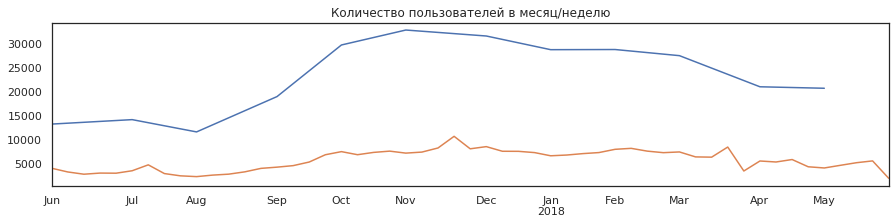

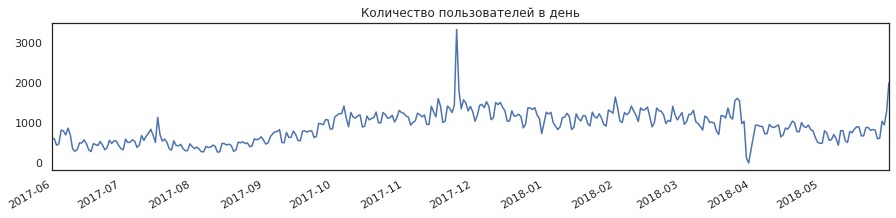

In [578]:
#Создадим столбцы с номером дня, недели и месяца посещения
df_visits['month'] = df_visits['start_session'].astype('datetime64[M]')
df_visits['week'] = df_visits['start_session'].astype('datetime64[W]')
df_visits['day'] = df_visits['start_session'].astype('datetime64[D]')
df_visits.head(3)

#Графики
df_visits.groupby('month')['uid'].nunique().plot(figsize=(15,3))
df_visits.groupby('week')['uid'].nunique().plot()
plt.title('Количество пользователей в месяц/неделю')
plt.xlabel('')
plt.ylabel('')
plt.show()

df_visits.groupby('day')['uid'].nunique().plot(figsize=(15,3))
plt.title('Количество пользователей в день')
plt.xlabel('')
plt.ylabel('')
plt.show()



На ежемесячном графике явно видно, что с августа 2017 года количество пользователей растет, достигает максимальных значений осенью-зимой, затем начинает плавно снижаться. Понедельный график имеет такой же тренд, но более сглаженный. Основанный на ежедневных данных график показывает, что пик в ноябре 2017 обусловлен аномальным большим значением в один день (нужно посмотреть, чем это может быть вызвано). Так же где-то в конце марта есть один день с аномально маленьким количеством пользователей (тоже нужно проверить).

In [579]:
#Найдем дни с аномально большим и малым количеством пользователей
visits_day=df_visits.groupby('day')['uid'].nunique().reset_index()
visits_day[(visits_day['uid']==visits_day['uid'].max())|(visits_day['uid']==visits_day['uid'].min())]

,day,uid
176,2017-11-24,3319
303,2018-03-31,1


24 ноября 2017 года количество посетителей взлетело 2 раза, затем опять опустилось до прежнего уровня. Нужно больше данных, чтоб понять причину аномалии. Посмотрим на график расходов, может быть была запущена рекламная акция в новый источник.

31 марта 2018 количество пользователей равно 1. 

In [580]:
df_costs.head(2)

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


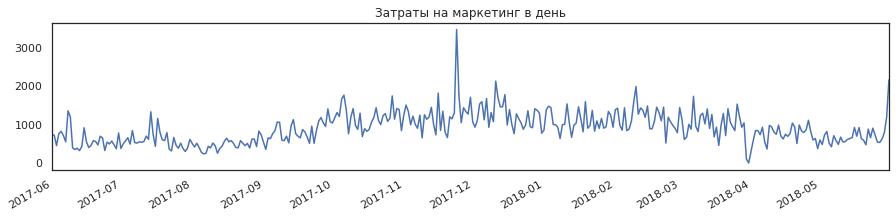

In [581]:
df_costs.groupby('date')['costs'].sum().plot(figsize=(15,3))
plt.title('Затраты на маркетинг в день')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [582]:
#Найдем дни с аномально большими и малыми затратами на маркетинг
costs_day=df_costs.groupby('date')['costs'].sum().reset_index()
costs_day[(costs_day['costs']==costs_day['costs'].max())|(costs_day['costs']==costs_day['costs'].min())]

,date,costs
176,2017-11-24,3458.86
303,2018-03-31,0.70


Наши предположения подтвердились, график затрат явно коррелирует с графиком, отражающим количество пользователей в этот день.

In [583]:
#Найдем среднее количество уникальных значений 'uid' в день, неделю и месяц
print('Среднее количество посетителей в месяц:', df_visits.groupby('month')['uid'].nunique().mean().round())
print('Среднее количество посетителей в неделю:', df_visits.groupby('week')['uid'].nunique().mean().round())
print('Среднее количество посетителей в день:', df_visits.groupby('day')['uid'].nunique().mean().round())

Среднее количество посетителей в месяц: 23228.0
Среднее количество посетителей в неделю: 5724.0
Среднее количество посетителей в день: 908.0


### Сколько сессий в день?

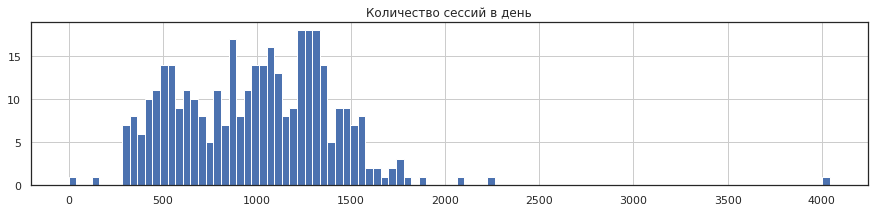

In [584]:
#Обзор значений на графике
df_visits.groupby('day')['uid'].count().hist(bins=100, figsize=(15,3))
plt.title('Количество сессий в день')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [585]:
#Найдем среднее количество сессий в день
print('Среднее количество сессий в день:', df_visits.groupby('day')['uid'].count().mean().round())

Среднее количество сессий в день: 987.0


Посмотрим динамику количества сессий в день в течение исследуемого периода, для наглядности агрегируем данные по неделям.

In [586]:
#Считаем среднее количество сессий в день и группируем по неделям 
sessions_per_day=df_visits.groupby(['week', 'day'])['uid'].count().reset_index()
sessions_per_day
sessions_per_day=sessions_per_day.groupby('week')['uid'].mean()

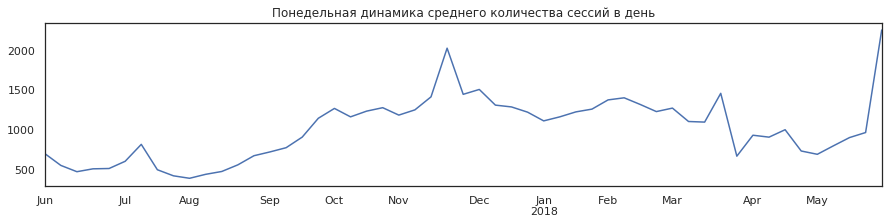

In [587]:
sessions_per_day.plot(figsize=(15,3))
plt.title('Понедельная динамика среднего количества сессий в день')
plt.xlabel('')
plt.ylabel('')
plt.show()

Тренд такой же как на графике с количеством посетителей. 


Посмотрим динамику количества сессий в день по устройствам и источникам.

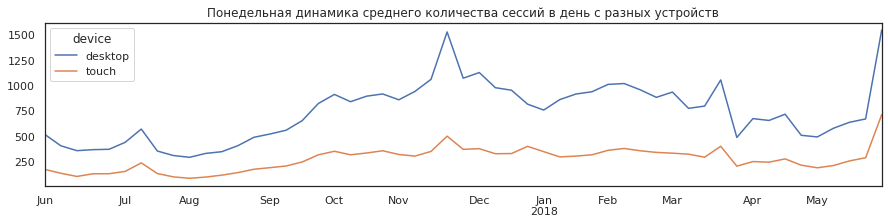

Среднее количество сессий в день c desctop: 721.0
Среднее количество сессий в день с touch: 267.0


In [588]:
#Понедельная динамика количества сессий в день по устройствам
sessions_per_day=df_visits.groupby(['device', 'week', 'day'])['uid'].count().reset_index()
visits_device=sessions_per_day.pivot_table(index='week',columns='device',values='uid',aggfunc='mean')
visits_device.plot(figsize=(15,3))
plt.title('Понедельная динамика среднего количества сессий в день с разных устройств')
plt.xlabel('')
plt.ylabel('')
plt.show()

#Найдем среднее количество сессий в день
print('Среднее количество сессий в день c desctop:', df_visits[df_visits['device']=='desktop'].groupby('day')['uid'].count().mean().round())
print('Среднее количество сессий в день с touch:', df_visits[df_visits['device']=='touch'].groupby('day')['uid'].count().mean().round())

Графики количества сессий с обоих типов устройств имеют одинаковый тренд. Количество сессий с desktop превышает количество с touch более , чем в два раза. 

### Сколько длится одна сессия?

In [589]:
#Подсчет длительности каждой сессии в минутах
df_visits['duration_min']=(df_visits['end_session']-df_visits['start_session'])/np.timedelta64(1, 'm')
df_visits.head(2)

,device,end_session,source_id,start_session,uid,month,week,day,duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,28.0


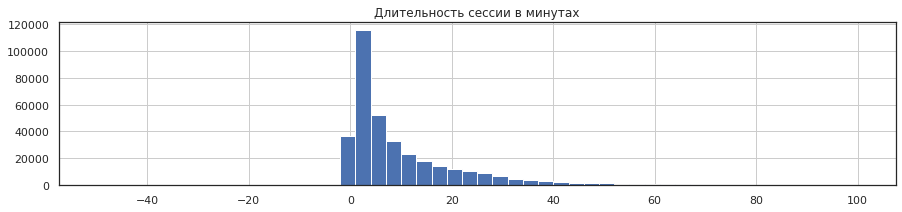

In [590]:
#Обзор значений на графике
df_visits['duration_min'].hist(bins=50, figsize=(15,3), range=(-50, 100))
plt.title('Длительность сессии в минутах')
plt.xlabel('')
plt.ylabel('')
plt.show()

Проверим, есть ли отрицательные значения. Скорее всего, это ошибки в данных. Посмотрим сколько таких строк.

In [591]:
#Вывод строк с отрицательными значениями
df_visits[df_visits['duration_min']<0]

,device,end_session,source_id,start_session,uid,month,week,day,duration_min
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-01,2018-03-22,2018-03-25,-32.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-01,2018-03-22,2018-03-25,-46.0


Всего два таких наблюдения. Причем в один день, нужно сообщить разработчикам, возможно, был какой-то сбой. Удалим их.

In [592]:
#Удаление ошибок
df_visits=df_visits[df_visits['duration_min']>=0]

Посмотрим есть ли выбросы в правом хвосте.

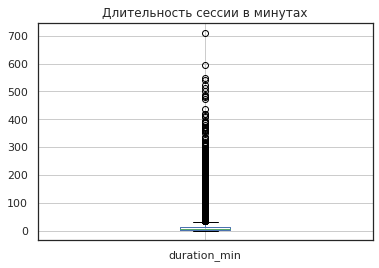

In [593]:
#Обзор значений на графике
df_visits.boxplot('duration_min')
plt.title('Длительность сессии в минутах')
plt.show()

In [594]:
print('Количество сессий, длительность которых более часа:', df_visits[df_visits['duration_min']>60]['uid'].count())

Количество сессий, длительность которых более часа: 6282


На графике сессии более часа обозначены как выбросы, но это не единичные ошибки. Это похоже на реальные данные. Возможно, такая длительность сессий - следствие того, что пользователь забыл покинуть сайт или занимлся другими делами в перерывах между действиями на сайте. Но это не похоже на ошибки в данных, мы не будем удалять эти наблюдения. Теперь можем посчитать среднюю длительность сессии.

Ответ на вопрос о средней длительности сессии будет зависеть от наших целей. Так как распределение у нас скошено, посмотрим значение моды и медианы.

In [595]:
print('Среднее:', df_visits['duration_min'].mean().round(), 'минут')
print('Медиана:', df_visits['duration_min'].median().round(), 'минут')
print('Мода:', df_visits['duration_min'].mode().round())
print()
print('Средняя длительность сеанса с desktop (медиана):', df_visits[df_visits['device']=='desktop']['duration_min'].median().round(), 'минут')
print('Средняя длительность сеанса с touch (медиана):', df_visits[df_visits['device']=='touch']['duration_min'].median().round(), 'минуты')

Среднее: 11.0 минут
Медиана: 5.0 минут
Мода: 0    1.0
dtype: float64

Средняя длительность сеанса с desktop (медиана): 6.0 минут
Средняя длительность сеанса с touch (медиана): 3.0 минуты


Среднее значение более чем в два раза превышает медиану из-за больших значений в правом хвосте распределения. Самое часто встречающееся значение длительности сеанса - это 1 минута. Но так же стоит учитывать, что половина клиентов всей выборки тратят на сеанс до 5 минут.

### Как часто люди возвращаются?

In [596]:
#Формирование столбца с датой первого посещения
first_activity_date=df_visits.groupby('uid')['start_session'].min()
first_activity_date.name = 'first_activity_date'
df_visits = df_visits.join(first_activity_date,on='uid')

In [597]:
first_activity_date

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: first_activity_date, Length: 228169, dtype: datetime64[ns]

In [598]:
df_visits.head(3)

,device,end_session,source_id,start_session,uid,month,week,day,duration_min,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,28.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01 01:54:00


In [599]:
#Формирование столбца с месяцем первого посещения
df_visits['first_activity_month'] = df_visits['first_activity_date'].astype('datetime64[M]')

In [600]:
#Формирование столбца с номером когорты
df_visits['cohort_lifetime']=((df_visits['month']-df_visits['first_activity_month'])/np.timedelta64(1, 'M')).round()

Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни».

In [601]:
#Сгруппируем данные по когорте и lifetime
cohorts = df_visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head(3)

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0.0,13259
1,2017-06-01,1.0,1043
2,2017-06-01,2.0,713


In [602]:
#Найдём исходное количество пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [603]:
#Переименуем столбец uid в cohort_users
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [604]:
#Объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0.0,13259,13259
1,2017-06-01,1.0,1043,13259
2,2017-06-01,2.0,713,13259
3,2017-06-01,3.0,814,13259
4,2017-06-01,4.0,909,13259


In [605]:
#Рассчитаем Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts.head(3)

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0.0,13259,13259,1.000000
1,2017-06-01,1.0,1043,13259,0.078664
2,2017-06-01,2.0,713,13259,0.053775


In [606]:
#Построим сводную таблицу 
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot.fillna('')

cohort_lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


In [607]:
(retention_pivot.mean(axis=0)*100).round(2)

cohort_lifetime
0.0     100.00
1.0       6.52
2.0       4.63
3.0       4.28
4.0       4.06
5.0       3.94
6.0       3.70
7.0       3.75
8.0       3.55
9.0       3.52
10.0      3.41
11.0      4.50
dtype: float64

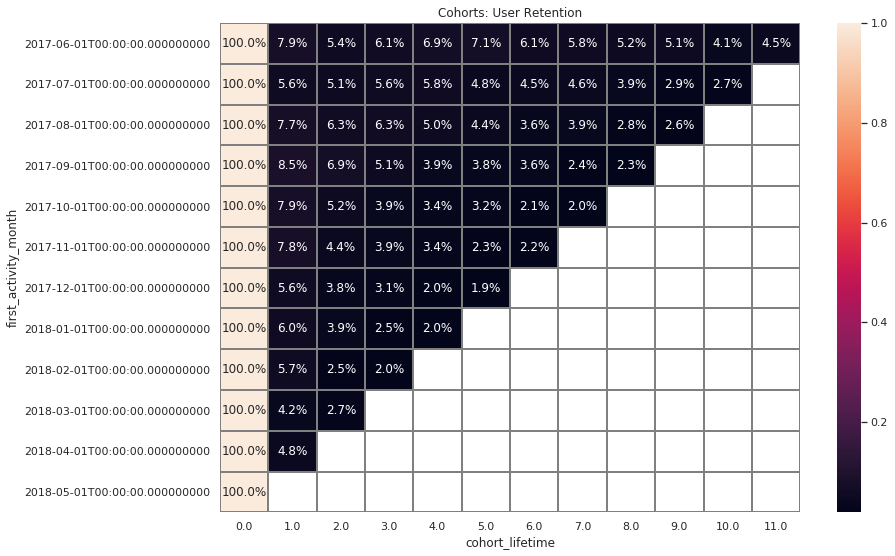

In [608]:
#Создадим тепловую карту
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

### Результаты по разделу "Продукт"

Обобщим результаты исследования по продукту.

#### Сколько людей пользуются в день, неделю, месяц?
- Среднее количество посетителей в месяц: 23228.0
- Среднее количество посетителей в неделю: 5724.0
- Среднее количество посетителей в день: 908.0

Графики показывают, что с начала периода количество посетителей постепенно росло. Наиболее высокие показатели были осенью-зимой, затем наблюдалось небольшое снижение. В ноябре 2017 года отмечен пик, который (как позже было выяснено) обусловлен резким увеличением количества пользователей в два раза 24 ноября 2017 года.

#### Сколько сессий в день?
- Среднее количество сессий в день: 987.0
        По устройствам:
        Среднее количество сессий в день c desctop: 721.0
        Среднее количество сессий в день с touch: 267.0

На исследуемом отрезке времени динамика среднего числа сессий совпадает с динамикой среднего количества пользователей. Среднее количество сессий в день превышает среднее количество пользователей всего на 1%. Из этого делаем вывод, что не более 1% пользователей совершают в день более одной сессии. 

#### Сколько длится одна сессия?
- Половина пользователей всей выборки тратят на сеанс до 5 минут. Причем самое часто встречающееся значение равно 1 минуте. 

Средняя длительность сеансов с девайсов типа touch в 2 раза (на 3 минуты) ниже, чем типа desktop.

#### Как часто люди возвращаются?

    Процент удержания клиентов по месяцам после их первой сессии:
        1.0       6.52 %
        2.0       4.63 %
        3.0       4.28 %
        4.0       4.06 %
        5.0       3.94 %
        6.0       3.70 %
        7.0       3.75 %
        8.0       3.55 %
        9.0       3.52 %
        10.0      3.41 %
        11.0      4.50 %
    
    

### ПРОДАЖИ

### Когда люди начинают покупать?

In [609]:
df_visits.tail(2)

,device,end_session,source_id,start_session,uid,month,week,day,duration_min,first_activity_date,first_activity_month,cohort_lifetime
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-02,2017-11-02,0.316667,2017-11-02 10:12:00,2017-11-01,0.0
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559,2017-09-01,2017-09-07,2017-09-10,0.316667,2017-09-10 13:13:00,2017-09-01,0.0


In [610]:
df_orders.tail(2)

,date,revenue,uid
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [611]:
#Добавление в таблицу orders столбика с датой (месяцем) первой сессий пользователя, совершившего заказ
df_orders=df_orders.merge(df_visits, on='uid', how='left')[['date', 'revenue', 'uid', 'first_activity_month', 'first_activity_date']]
df_orders.tail(4)

,date,revenue,uid,first_activity_month,first_activity_date
761803,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00
761804,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00
761805,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00
761806,2018-06-01 00:02:00,3.42,83872787173869366,2018-05-01,2018-05-31 23:59:00


In [612]:
#Формирование столбца с датой первой покупки
first_order_date=df_orders.groupby('uid')['date'].min()
first_order_date.name = 'first_order_date'
df_orders = df_orders.join(first_order_date,on='uid')


In [613]:
df_orders.head(2)

,date,revenue,uid,first_activity_month,first_activity_date,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01 00:25:00


In [614]:
#Формирование столбца с количеством дней/минут от начала первой сессии до первой покупки 
df_orders['days_to_buy']=((df_orders['first_order_date']-df_orders['first_activity_date'])/np.timedelta64(1, 'D')).round()
df_orders['hours_to_buy']=(df_orders['first_order_date']-df_orders['first_activity_date'])/np.timedelta64(1, 'h')
df_orders['min_to_buy']=(df_orders['first_order_date']-df_orders['first_activity_date'])/np.timedelta64(1, 'm')
df_orders['sec_to_buy']=(df_orders['first_order_date']-df_orders['first_activity_date'])/np.timedelta64(1, 's')

In [615]:
#Проверим корректность значений, все ли они больше нуля
print('Доля заказов, где время от начала первой сессии до первой покупки нулевое: {:.0%}'.format(df_orders['uid'][df_orders['sec_to_buy']==0].count()/len(df_orders)))

Доля заказов, где время от начала первой сессии до первой покупки нулевое: 12%


Целых 12% заказов сделаны после 0 секунд от начала первой сессии. Это похоже на ошибки в данных. С другой стороны, это может быть связано с технологией совершения заказа. Если клиент принимает решение о покупке на стороннем сайте, а затем при оформлении заказа его автоматически выкидывает на сайт Афиши и транзакция автоматически совершается там. В общем, нужно больше информации, чтоб понять причину нулевых значений. 

Но в любом случае эти значения могут искажать распределение, создадим дополнительную выборку с условием, что время для заказа больше 0 секунд. Сравним результаты.

In [616]:
df_orders_1=df_orders[df_orders['sec_to_buy']>0]

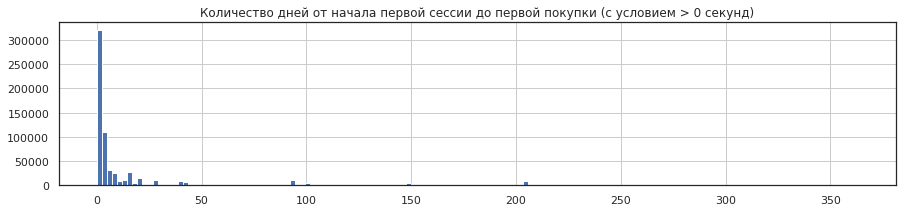

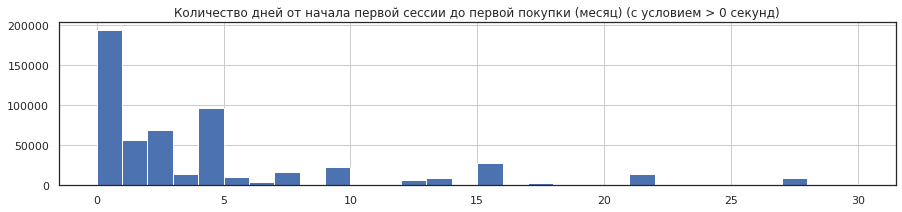

In [617]:
#График распределения количества дней от начала первой сессии до первой покупки
df_orders_1['days_to_buy'].hist(bins=150, figsize=(15,3))
plt.title('Количество дней от начала первой сессии до первой покупки (с условием > 0 секунд)')
plt.xlabel('')
plt.ylabel('')
plt.show()
#График распределения количества дней от начала первой сессии до первой покупки
df_orders_1['days_to_buy'].hist(bins=30, figsize=(15,3), range=(0,30))
plt.title('Количество дней от начала первой сессии до первой покупки (месяц) (с условием > 0 секунд)')
plt.xlabel('')
plt.ylabel('')
plt.show()

На графике видно, что большинство людей совершают покупку в первые дни после посещения сайта, но не все.

In [618]:
#Описательная статистика в днях (для первоначальной выборки)
print('Медиана равна', df_orders['days_to_buy'].median())
print('Ср.знач. равно', df_orders['days_to_buy'].mean().round())
print('Мoда равна', df_orders['days_to_buy'].mode())


Медиана равна 2.0
Ср.знач. равно 18.0
Мoда равна 0    0.0
dtype: float64


In [619]:
#Описательная статистика в днях (для отсеченной выборки)
print('Медиана равна', df_orders_1['days_to_buy'].median())
print('Ср.знач. равно', df_orders_1['days_to_buy'].mean().round())
print('Мoда равна', df_orders_1['days_to_buy'].mode())

Медиана равна 4.0
Ср.знач. равно 20.0
Мoда равна 0    0.0
dtype: float64


Большое количество покупателей покупают в день, когда впервые посетили сайт. Покупатели распределены неравномерно по дням, ближе к нулю концентрация выше, но есть и отдельные большие значения (отсюда и сильный разрыв между медианой и средним).

Дополнительно рассмотрим первые сутки.

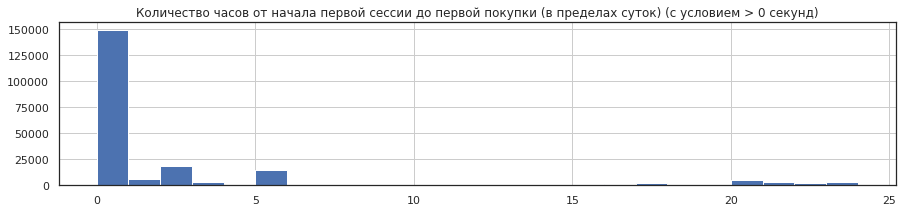

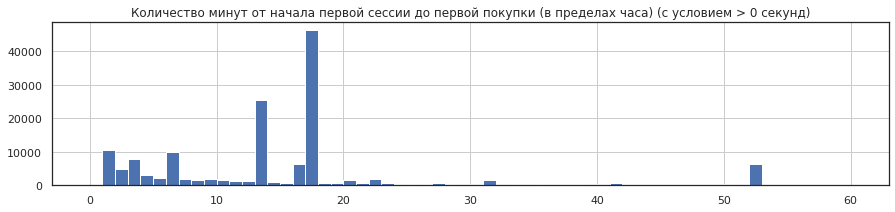

In [620]:
#График распределения количества минут от начала первой сессии до первой покупки (для отсеченной выборки)
df_orders_1['hours_to_buy'].hist(bins=24, range=(0,24), figsize=(15,3))
plt.title('Количество часов от начала первой сессии до первой покупки (в пределах суток) (с условием > 0 секунд)')
plt.xlabel('')
plt.ylabel('')
plt.show()

#График распределения количества минут от начала первой сессии до первой покупки (для отсеченной выборки)
df_orders_1['min_to_buy'].hist(bins=60, range=(0,60), figsize=(15,3))
plt.title('Количество минут от начала первой сессии до первой покупки (в пределах часа) (с условием > 0 секунд)')
plt.xlabel('')
plt.ylabel('')
plt.show()

Итак, момент, когда пользователи начинают покупать, довольно неоднозначный. Для первоначальной выборки за первые два дня половина пользователей из выборки совершают покупку. Однако, были обнаружены подозрительные строки со значением в ноль секунд. Если принять их за ошибки в данных, то время, необходимое для того, чтоб половина пользователей из выборки сделали заказ, увеличивается до 4 дней.

В любом случае большое количество клиентов совершают заказ в первый день.

Если рассматривать такой вопрос более детально (например в минутах), необходимо учитывать с какой целью мы его задаем. Возможно, здесь было бы уместно разделить пользователей на группы и смотреть среднее время принятия решения о покупке для каждой группы отдельно. 

Например, на последнем графике видно, что большая часть совершают заказ в первый час. Если мы рассматриваем только этих клиентов, то видим, что большому количеству людей понадобилось для заказа около 17 минут. Хотя первоначально для общей выборки этого было не видно.

Таким образом, ответ на такой вопрос, определяемый по среднему/медианному значению или моде, является очень расплывчатым. И для конкретной прикладной задачи лучше рассматривать его отдельно.

Далее, разделив клиентов на когорты по месяцам, мы построим тепловую карту, показывающую "Когда клиенты начинают покупать". Возможно, так результаты будут более наглядными.

In [621]:
#Формирование столбца с месяцем первой посещения
df_orders['first_order_month'] = df_orders['first_order_date'].astype('datetime64[M]')

In [622]:
#Формирование столбца с количеством месяцев между первой сессией и первой покупкой
df_orders['age']=((df_orders['first_order_month']-df_orders['first_activity_month'])/np.timedelta64(1, 'M')).round()

In [623]:
df_orders.tail()

,date,revenue,uid,first_activity_month,first_activity_date,first_order_date,days_to_buy,hours_to_buy,min_to_buy,sec_to_buy,first_order_month,age
761802,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00,2018-05-31 23:56:00,220.0,5291.40,317484.0,19049040.0,2018-05-01,7.0
761803,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00,2018-05-31 23:56:00,220.0,5291.40,317484.0,19049040.0,2018-05-01,7.0
761804,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00,2018-05-31 23:56:00,220.0,5291.40,317484.0,19049040.0,2018-05-01,7.0
761805,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-01,2017-10-23 12:32:00,2018-05-31 23:56:00,220.0,5291.40,317484.0,19049040.0,2018-05-01,7.0
761806,2018-06-01 00:02:00,3.42,83872787173869366,2018-05-01,2018-05-31 23:59:00,2018-06-01 00:02:00,0.0,0.05,3.0,180.0,2018-06-01,1.0


In [624]:
#Сгруппируем данные по когорте
cohorts_3 = df_orders.groupby('first_activity_month').agg({'uid':'nunique'}).reset_index()

In [625]:
cohorts_3.head(2)

,first_activity_month,uid
0,2017-06-01,2923
1,2017-07-01,2458


In [626]:
#Изменение некоторых названий
cohorts_3=cohorts_3.rename(columns={"uid": "cohort_count"})
list(cohorts_3)

['first_activity_month', 'cohort_count']

In [627]:
#Сгруппируем данные по когорте и age
cohorts_2 = df_orders.groupby(['first_activity_month','age']).agg({'uid':'nunique'}).reset_index()
cohorts_2.head()

,first_activity_month,age,uid
0,2017-06-01,0.0,2023
1,2017-06-01,1.0,170
2,2017-06-01,2.0,67
3,2017-06-01,3.0,107
4,2017-06-01,4.0,119


In [628]:
#Объединим таблицы
cohorts_2=cohorts_2.merge(cohorts_3, on='first_activity_month', how='left')

In [629]:
cohorts_2.head(3)

,first_activity_month,age,uid,cohort_count
0,2017-06-01,0.0,2023,2923
1,2017-06-01,1.0,170,2923
2,2017-06-01,2.0,67,2923


In [630]:
cohorts_2['success']=cohorts_2['uid']/cohorts_2['cohort_count']

In [631]:
#Построим сводную таблицу и создадим тепловую карту
orders_pivot = cohorts_2.pivot_table(index='first_activity_month',columns='age',values='success',aggfunc='sum')
orders_pivot.fillna('')

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_activity_month,,,,,,,,,,,,
2017-06-01,0.692097,0.058159,0.0229217,0.0366062,0.0407116,0.0314745,0.0266849,0.0201847,0.0218953,0.0218953,0.00889497,0.0184742
2017-07-01,0.713181,0.038649,0.0402766,0.0406835,0.0362083,0.0313263,0.0272579,0.0252238,0.0203417,0.0134255,0.0134255,
2017-08-01,0.701917,0.068565,0.0534573,0.0424172,0.0377687,0.0220802,0.0226612,0.0220802,0.0145264,0.0145264,,
2017-09-01,0.738064,0.087639,0.0467626,0.0333551,0.0192937,0.0248528,0.0232178,0.0130804,0.0137345,,,
2017-10-01,0.803976,0.069902,0.0380504,0.0243694,0.0207354,0.0196665,0.0104746,0.012826,,,,
2017-11-01,0.787658,0.091976,0.0363679,0.0239324,0.0297982,0.0150164,0.0152511,,,,,
2017-12-01,0.856897,0.058174,0.0282278,0.0274914,0.0110457,0.018164,,,,,,
2018-01-01,0.847708,0.078230,0.0365502,0.0160308,0.0214812,,,,,,,
2018-02-01,0.895166,0.063402,0.0194601,0.0219711,,,,,,,,


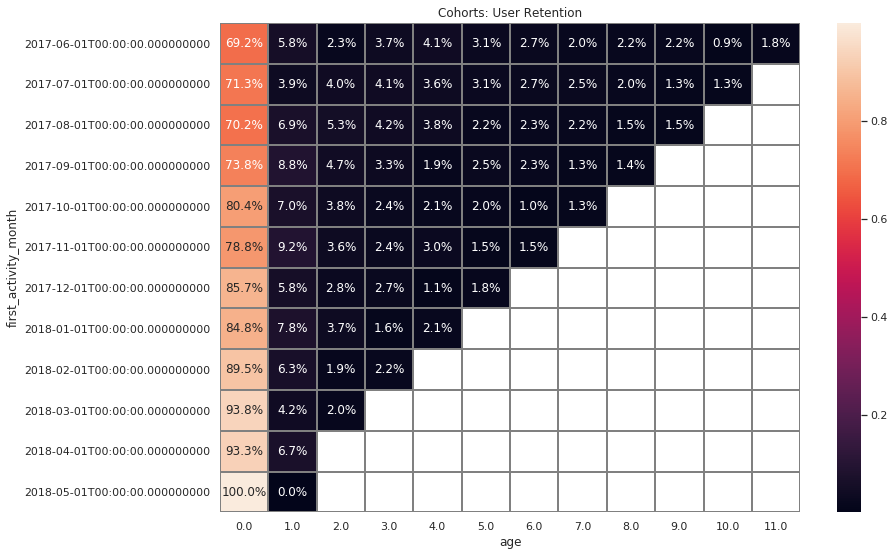

In [632]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(orders_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Теперь более наглядно видно, что с июня 2017 время на принятие решения о покупке постепенно уменьшалось. 

In [633]:
(orders_pivot.mean(axis=0)*100).round(2)

age
0.0     82.56
1.0      6.04
2.0      3.42
3.0      2.97
4.0      2.71
5.0      2.32
6.0      2.09
7.0      1.87
8.0      1.76
9.0      1.66
10.0     1.12
11.0     1.85
dtype: float64

### Сколько раз покупают за период?

In [634]:
df_orders.head(3)

,date,revenue,uid,first_activity_month,first_activity_date,first_order_date,days_to_buy,hours_to_buy,min_to_buy,sec_to_buy,first_order_month,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01 00:10:00,0.0,0.016667,1.0,60.0,2017-06-01,0.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01 00:25:00,0.0,0.183333,11.0,660.0,2017-06-01,0.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:27:00,0.0,0.033333,2.0,120.0,2017-06-01,0.0


In [635]:
#Добавим столбики - день, неделя, месяц покупки
df_orders['month_order'] = df_orders['date'].astype('datetime64[M]')
df_orders['week_order'] = df_orders['date'].astype('datetime64[W]')
df_orders['day_order'] = df_orders['date'].astype('datetime64[D]')

In [636]:
#Среднее количество заказов в день, неделю и месяц
print('Среднее количество заказов в день:', df_orders.groupby('day_order')['uid'].count().mean().round())
print('Среднее количество заказов в неделю:', df_orders.groupby('week_order')['uid'].count().mean().round())
print('Среднее количество заказов в месяц:', df_orders.groupby('month_order')['uid'].count().mean().round())

Среднее количество заказов в день: 2093.0
Среднее количество заказов в неделю: 14374.0
Среднее количество заказов в месяц: 58601.0


Как менялись эти значения во времени посмотрим на графиках.

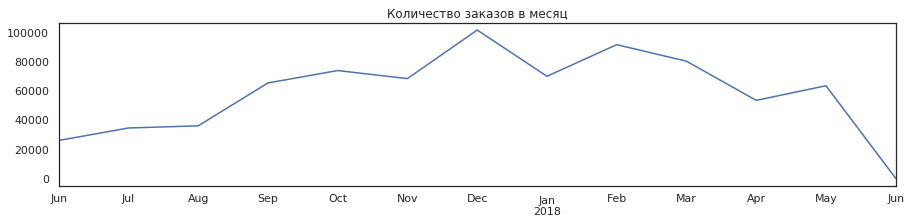

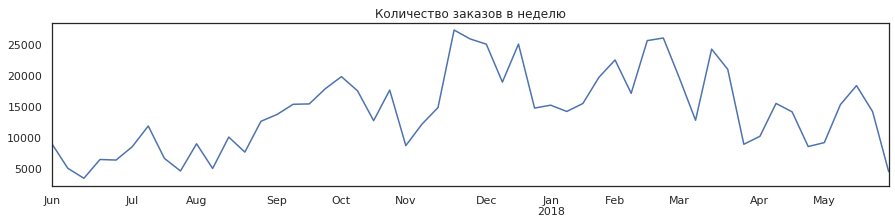

In [637]:
#Посмотрим распределение по времени
df_orders.groupby('month_order')['uid'].count().plot(figsize=(15,3))
plt.title('Количество заказов в месяц')
plt.xlabel('')
plt.ylabel('')
plt.show()

df_orders.groupby('week_order')['uid'].count().plot(figsize=(15,3))
plt.title('Количество заказов в неделю')
plt.xlabel('')
plt.ylabel('')
plt.show()

Опять видим пик в середине исследуемого периода, как и на графиках с расходами и количеством клиентов.

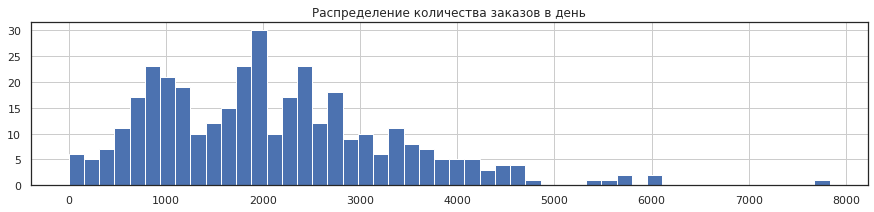

In [638]:
df_orders.groupby('day_order')['uid'].count().hist(bins=50, figsize=(15,3))
plt.title('Распределение количества заказов в день')
plt.xlabel('')
plt.ylabel('')
plt.show()

Среднее количество заказов в день около 2000. От этого значения влево и вправо растягиваются два плавных хвоста. Аномальных скачков не видно.

### Какой средний чек?

In [639]:
df_orders.head(2)

,date,revenue,uid,first_activity_month,first_activity_date,first_order_date,days_to_buy,hours_to_buy,min_to_buy,sec_to_buy,first_order_month,age,month_order,week_order,day_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01 00:10:00,0.0,0.016667,1.0,60.0,2017-06-01,0.0,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01 00:25:00,0.0,0.183333,11.0,660.0,2017-06-01,0.0,2017-06-01,2017-06-01,2017-06-01


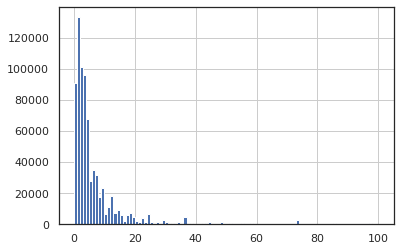

In [640]:
df_orders['revenue'].hist(range=(0,100), bins=100)

Распределение скошено. Посмотрим описательную статистику.

In [641]:
df_orders['revenue'].describe()

count    761807.000000
mean          9.139070
std          38.477291
min           0.000000
25%           1.830000
50%           3.670000
75%           7.330000
max        2633.280000
Name: revenue, dtype: float64

In [642]:
df_orders['revenue'].mode()

0    1.83
dtype: float64

Самое часто встречающееся значение 1.83.

In [643]:
print('Средний чек равен:', df_orders['revenue'].median().round())

Средний чек равен: 4.0


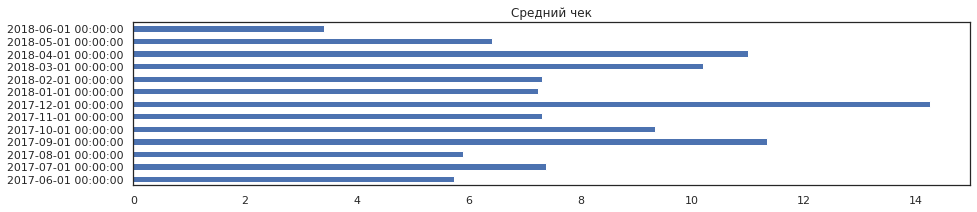

In [644]:
df_orders.groupby('month_order')['revenue'].mean().plot(figsize=(15,3), kind='barh')
plt.title('Средний чек')
plt.xlabel('')
plt.ylabel('')
plt.show()


Опять видим график с пиковым значение в середине периода. До этой точки и после нее значения ниже, но тренд не явный, значения то растут , то падают.

### Сколько денег приносят? (LTV)

LTV — «пожизненная» ценность клиента — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

#### 1. Беру таблицу с заказами 

In [645]:
df_orders_0.tail(2)

,date,revenue,uid
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [646]:
#Формирование столбца с датой первой покупки
first_order_date=df_orders_0.groupby('uid')['date'].min()
first_order_date.name = 'first_order_date'
df_orders = df_orders_0.join(first_order_date,on='uid')

In [647]:
df_orders.tail(2)

,date,revenue,uid,first_order_date
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01 00:02:00


In [648]:
df_orders['month_order']=df_orders['date'].astype('datetime64[M]')
df_orders['first_order_month']=df_orders['first_order_date'].astype('datetime64[M]')

In [649]:
df_orders

,date,revenue,uid,first_order_date,month_order,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01


#### 2. Делю людей на 13 когорт в зависимости от того, в каком месяце они совершили первый заказ.

#### 3. Определяю число клиентов в каждой когорте. (Один и тот же клиент не может входить сразу в две когорты).

Чтоб посчитать количество человек в каждой когорте, сгруппируем по месяцу первого заказа

In [650]:
#Кол-во клиентов в каждой когорте
cohort_sizes = df_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


#### 4. Нахожу общую сумму заказов по месяцам отдельно для каждой когорты (не накопительным итогом, а отдельно за каждый месяц).

In [651]:
#Выручка по месяцам для каждой когорты
cohort_revenue = df_orders.groupby(['first_order_month', 'month_order']).agg({'revenue': 'sum'}).reset_index()
cohort_revenue.columns = ['first_order_month','order_month', 'revenue']
cohort_revenue.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


#### 5. Соединяю таблицы с суммами заказав и количеством людей в когорте.

In [652]:
#Соединим таблицы
df_ltv=pd.merge(cohort_sizes, cohort_revenue, on='first_order_month')
df_ltv

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Теперь видим для каждой когорты отдельно сколько клиентов совершали заказ в месяц и общую сумму заказов.

#### 6. Добавляю столбик "возраст клиента".

In [653]:
#возраст клиента - сколько месяцев клиент с нами
df_ltv['age'] = (df_ltv['order_month'] - df_ltv['first_order_month']) / np.timedelta64(1, 'M')
df_ltv['age'] = df_ltv['age'].round().astype('int')
df_ltv

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4
...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,0


#### 7. Столбик ltv рассчитываю путем деления общей выручки за месяц на количество людей в когорте.

In [654]:
#Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в когорте
df_ltv['ltv'] = df_ltv['revenue'] / df_ltv['n_buyers']
df_ltv

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,0,4.660562


#### 8. Далее строю общую таблицу, где строки - номера когорт, столбцы - возраст клиента на момент заказа, значения - сколько денег в среднем принес один клиент и этой когорты, значения выводятся суммирующим итогом по месяцам (по каждой когорте отдельно).

Представим в таблице по каждой когорте отдельно, сколько денег приносит в среднем покупатель за опр. число месяцев "с нами"

In [655]:
#Сводная таблица
output = df_ltv.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
output.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


#### 9. LTV по каждой когорте представлен как сумма денег, которую в среднем успел принести один клиент из этой когорты.

Теперь представим ltv по каждой когорте

In [656]:
df_ltv.groupby('first_order_month')['ltv'].sum().round(2).reset_index()

,first_order_month,ltv
0,2017-06-01,11.88
1,2017-07-01,8.39
2,2017-08-01,8.47
3,2017-09-01,13.44
4,2017-10-01,6.36
5,2017-11-01,6.40
6,2017-12-01,7.64
7,2018-01-01,4.94
8,2018-02-01,4.59
9,2018-03-01,5.46


Проанализируем первую когорту, т.к. значение lifetime здесь более полное. LTV первой когорты равен 11.88 руб.

Однако мы видим, что с каждой новой когортой продажи падают. Уже во второй когорте за период в 11 месяцев LTV равен 8.39 руб. 

### Результаты по разделу ПРОДАЖИ

Обобщим результаты исследования по продажам.

#### Когда люди начинают покупать?

Итак, момент, когда пользователи начинают покупать, довольно неоднозначный. Для первоначальной выборки за первые два дня половина пользователей из выборки совершают покупку.

Большое количество клиентов покупают в день, когда впервые посетили сайт. Покупатели распределены неравномерно по дням, ближе к нулю концентрация выше, но есть и отдельные большие значения (отсюда и сильный разрыв между медианой и средним).

    Доля людей, совершивших первую покупку после опр.кол-ва месяцев от первого визита:
    0.0     82.56 %
    1.0      6.04 %
    2.0      3.42 %
    3.0      2.97 %
    4.0      2.71 %
    5.0      2.32 %
    6.0      2.09 %
    7.0      1.87 %
    8.0      1.76 %
    9.0      1.66 %
    10.0     1.12 %
    11.0     1.85 %

#### Сколько раз покупают за период?

- Среднее количество заказов в день: 2093.0
- Среднее количество заказов в неделю: 14374.0
- Среднее количество заказов в месяц: 58601.0

Динамика заказов во времени совпадает с графиками числа пользователей и количества посещений. Тоже скачок в середине периода, в хвостах значения ниже.

#### Какой средний чек?

- Средний чек равен: 4.0 
- Самое часто встречающееся значение 1.83.

#### Сколько денег приносят? (LTV)

    LTV первой когорты (lifetime = год) равен 11.88 руб.
    Однако по итоговой таблице видно, что клиенты пришедшие позже, приносят значительно меньше денег. Например, LTV второй когорты (lifetime = 11 месяцев) равен 8.39 руб. 
    
             cohort	    ltv
        0	2017-06-01	11.88
        1	2017-07-01	8.39
        2	2017-08-01	8.47
        3	2017-09-01	13.44
        4	2017-10-01	6.36
        5	2017-11-01	6.40
        6	2017-12-01	7.64
        7	2018-01-01	4.94
        8	2018-02-01	4.59
        9	2018-03-01	5.46
       10	2018-04-01	5.19
       11	2018-05-01	4.66
       12	2018-06-01	3.42	

### МАРКЕТИНГ

CAC — стоимость привлечения клиента - сумма денег, во сколько обходится новый клиент компании. Экономика одного покупателя сходится, если LTV больше CAC.

### Сколько денег потратили?

In [657]:
#Столбец с месяцем расходов
df_costs['month'] = df_costs['date'].astype('datetime64[M]')

In [658]:
cost_pivot=df_costs.pivot_table(
        index='month', 
        columns='source_id', 
        values='costs', 
        aggfunc='sum').round()

cost_pivot

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1126.0,2427.0,7732.0,3515.0,2616.0,285.0,314.0
2017-07-01,1073.0,2333.0,7674.0,3530.0,2998.0,303.0,330.0
2017-08-01,952.0,1811.0,6144.0,3217.0,2185.0,249.0,233.0
2017-09-01,1502.0,2986.0,9964.0,5192.0,3849.0,416.0,461.0
2017-10-01,2316.0,4845.0,15737.0,6421.0,5767.0,609.0,627.0
2017-11-01,2445.0,5248.0,17025.0,5389.0,6325.0,683.0,792.0
2017-12-01,2341.0,4898.0,16220.0,7680.0,5873.0,658.0,646.0
2018-01-01,2186.0,4158.0,14809.0,5833.0,5372.0,547.0,614.0
2018-02-01,2204.0,4474.0,14229.0,5712.0,5071.0,552.0,481.0


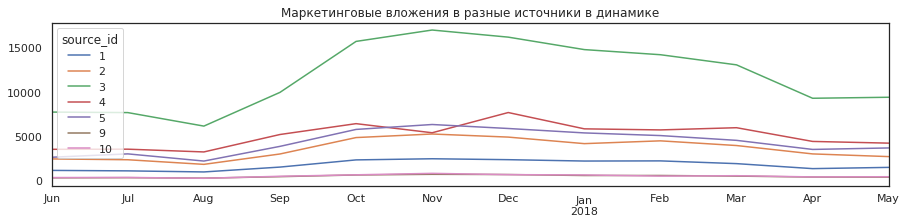

In [659]:
#График 'Маркетинговые вложения в разные источники в динамике'
cost_pivot.plot(figsize=(15,3))
plt.title('Маркетинговые вложения в разные источники в динамике')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [660]:
#Сумма расходов на каждый ресурс
cost_sources=cost_pivot.sum(axis=0).round().sort_values()
cost_sources

source_id
9       5517.0
10      5822.0
1      20833.0
2      42806.0
5      51757.0
4      61073.0
3     141323.0
dtype: float64

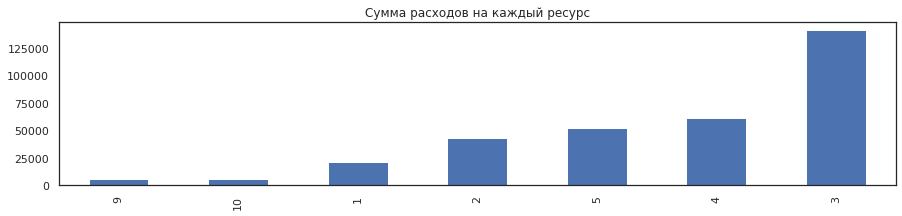

In [661]:
#График
cost_pivot.sum(axis=0).round().sort_values().plot(kind='bar', figsize=(15,3))
plt.title('Сумма расходов на каждый ресурс')
plt.xlabel('')
plt.ylabel('')
plt.show()


In [662]:
#Сумма расходов по месяцам
costs_months=cost_pivot.sum(axis=1).round().reset_index()
costs_months

,month,0
0,2017-06-01,18015.0
1,2017-07-01,18241.0
2,2017-08-01,14791.0
3,2017-09-01,24370.0
4,2017-10-01,36322.0
5,2017-11-01,37907.0
6,2017-12-01,38316.0
7,2018-01-01,33519.0
8,2018-02-01,32723.0
9,2018-03-01,30415.0


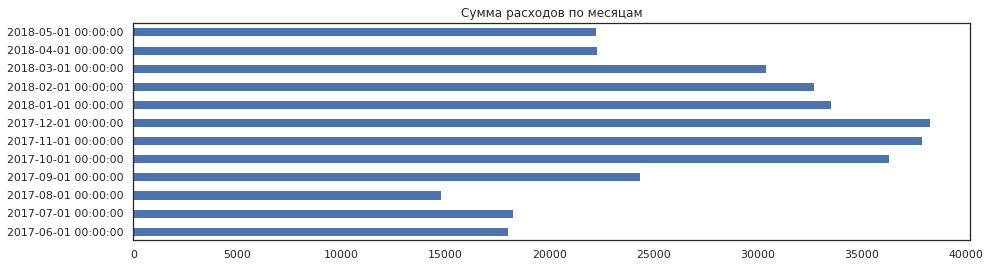

In [663]:
#График
cost_pivot.sum(axis=1).round().plot(kind='barh', figsize=(15,4))
plt.title('Сумма расходов по месяцам')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [664]:
print('Общая сумма расходов на маркетинг:', cost_pivot.sum(axis=1).sum(), 'руб.')

Общая сумма расходов на маркетинг: 329131.0 руб.


### Сколько стоило привлечение одного покупателя из каждого источника?

In [665]:
#Таблица расходов
df_costs.head(2)

,source_id,date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


In [666]:
#считаем общие расходы по источникам
sources_costs = df_costs.groupby('source_id')['costs'].sum().reset_index()
sources_costs

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [667]:
#Данные о кол-ве покупателей возьмем из таблицы orders
buyers=df_orders['uid'].reset_index()
buyers.head(2)

,index,uid
0,0,10329302124590727494
1,1,11627257723692907447


In [668]:
#Чтоб понять из какого источника пришел покупатель, обратимся к таблице visits
df_visits.head(2)

,device,end_session,source_id,start_session,uid,month,week,day,duration_min,first_activity_date,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,0.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,0.0


In [669]:
#Возмем только строки с первыми визитами
df_visits_first=df_visits[df_visits['start_session']==df_visits['first_activity_date']]
df_visits_first=df_visits_first[['uid', 'source_id']]
df_visits_first.head(2)

,uid,source_id
0,16879256277535980062,4
1,104060357244891740,2


In [670]:
#Объединим таблицу с заказами и первыми визитами по полю uid
orders_sources=pd.merge(buyers, df_visits_first, on='uid')
orders_sources.head()


,index,uid,source_id
0,0,10329302124590727494,1
1,1,11627257723692907447,2
2,2,17903680561304213844,2
3,3,16109239769442553005,2
4,4,14200605875248379450,3


In [671]:
#Находим количество покупателей по источникам
orders_sources=orders_sources.groupby('source_id')['uid'].nunique().reset_index()
orders_sources

,source_id,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [672]:
#Соединяем таблицы с расходами и количеством клиентов по источникам
sources_costs = pd.merge(sources_costs, orders_sources, on='source_id')

In [673]:
sources_costs

,source_id,costs,uid
0,1,20833.27,2899
1,2,42806.04,3506
2,3,141321.63,10473
3,4,61073.60,10296
4,5,51757.10,6931
5,9,5517.49,1088
6,10,5822.49,1329


In [674]:
sources_costs['cac_sources']=sources_costs['costs']/sources_costs['uid']

In [675]:
sources_costs[['source_id', 'cac_sources']].sort_values(by='cac_sources')

,source_id,cac_sources
6,10,4.381106
5,9,5.071222
3,4,5.931779
0,1,7.186364
4,5,7.467479
1,2,12.209367
2,3,13.493901


10 источник оказался самым дешевым, 3 - самым дорогим.

### На сколько окупились расходы? (ROI) 

In [683]:
#Группируем расходы по месяцам
costs_months_last=df_costs.groupby('month')['costs'].sum().reset_index()
costs_months_last

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [684]:
df_orders.head(2)

,date,revenue,uid,first_order_date,month_order,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01


In [685]:
#Группируем выручку по месяцам
order=df_orders.groupby('first_order_month')['revenue'].sum().reset_index()
order

,first_order_month,revenue
0,2017-06-01,24031.69
1,2017-07-01,16127.92
2,2017-08-01,11606.26
3,2017-09-01,34676.32
4,2017-10-01,27603.45
5,2017-11-01,26098.99
6,2017-12-01,33485.74
7,2018-01-01,16663.13
8,2018-02-01,16750.50
9,2018-03-01,19273.41


In [686]:
#Соединяем таблицы
romi=pd.merge(costs_months_last, order, left_on='month', right_on='first_order_month')

In [687]:
romi

,month,costs,first_order_month,revenue
0,2017-06-01,18015.00,2017-06-01,24031.69
1,2017-07-01,18240.59,2017-07-01,16127.92
2,2017-08-01,14790.54,2017-08-01,11606.26
3,2017-09-01,24368.91,2017-09-01,34676.32
4,2017-10-01,36322.88,2017-10-01,27603.45
5,2017-11-01,37907.88,2017-11-01,26098.99
6,2017-12-01,38315.35,2017-12-01,33485.74
7,2018-01-01,33518.52,2018-01-01,16663.13
8,2018-02-01,32723.03,2018-02-01,16750.50
9,2018-03-01,30415.27,2018-03-01,19273.41


In [688]:
#Находим romi по месяцам путем деления общей выручки на общие расходы 
romi['romi']=(romi['revenue']/romi['costs']).round(2)

In [689]:
romi

,month,costs,first_order_month,revenue,romi
0,2017-06-01,18015.00,2017-06-01,24031.69,1.33
1,2017-07-01,18240.59,2017-07-01,16127.92,0.88
2,2017-08-01,14790.54,2017-08-01,11606.26,0.78
3,2017-09-01,24368.91,2017-09-01,34676.32,1.42
4,2017-10-01,36322.88,2017-10-01,27603.45,0.76
5,2017-11-01,37907.88,2017-11-01,26098.99,0.69
6,2017-12-01,38315.35,2017-12-01,33485.74,0.87
7,2018-01-01,33518.52,2018-01-01,16663.13,0.50
8,2018-02-01,32723.03,2018-02-01,16750.50,0.51
9,2018-03-01,30415.27,2018-03-01,19273.41,0.63


В итоге получаем, во сколько раз окупились вложения в маркетинг в каждом месяце отдельно.

In [690]:
romi[['month', 'romi']]

,month,romi
0,2017-06-01,1.33
1,2017-07-01,0.88
2,2017-08-01,0.78
3,2017-09-01,1.42
4,2017-10-01,0.76
5,2017-11-01,0.69
6,2017-12-01,0.87
7,2018-01-01,0.50
8,2018-02-01,0.51
9,2018-03-01,0.63


Расходы окупились только за июнь и сентябрь 2017.

### Результаты по разделу МАРКЕТИНГ

Обобщим результаты исследования по маркетингу.

#### Сколько денег потратили? Всего / на каждый источник / по времени

    Сумма расходов на каждый источник:
    9       5517.0
    10      5822.0
    1      20833.0
    2      42806.0
    5      51757.0
    4      61073.0
    3     141323.0
    
    Сумма расходов по месяцам:

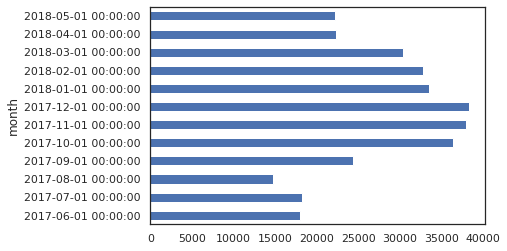

  
    Всего было потрачено 329 131 руб.

#### Сколько стоило привлечение одного покупателя из каждого источника? (CAC)

     source_id	cac_sources
           10	4.381106
        	9	5.071222
        	4	5.931779
        	1	7.186364
        	5	7.467479
        	2	12.209367
        	3	13.493901


#### На сколько окупились расходы? (ROI)

    Во сколько раз выручка превысила расходы по месяцам:
             month	     romi
        0	2017-06-01	1.33
        1	2017-07-01	0.88
        2	2017-08-01	0.78
        3	2017-09-01	1.42
        4	2017-10-01	0.76
        5	2017-11-01	0.69
        6	2017-12-01	0.87
        7	2018-01-01	0.50
        8	2018-02-01	0.51
        9	2018-03-01	0.63
       10	2018-04-01	0.53
       11	2018-05-01	0.63
    
Видим, что маркетинговые расходы за июнь 2017 окупились в 1.33 раза. 

Расходы за сентябрь 2017 окупились в 1.42 раза.

Расходы за остальные месяцы еще не окупились.

## Вывод 

На графике расходов на маркетинг видно, что они были максимальными в конце 2017 года, но потом стали уменьшаться. Причем сравнивая графики расходов на маркетинг и количества клиентов/посещений в динамике видна явная зависимость. То есть доп.расходы на маркетинг заметно увеличивали приток посетителей. 

Имеющиеся данные показывают, что максимальные вложения на маркетинг за исследуемый период были сделаны в источник №3 - 141 323 руб.. На втором месте источник №4 -61 073 руб., затем источник №5 - 51 757 руб. Далее видим, что самое дорогое привлечение одного покупателя происходит через источники №3 (13.49 руб на чел.), №2 (12.21 руб. на чел.), №5 (7.47 руб. на чел.).

Самое дешевое привлечение через источники №10 (4.38 руб. на чел.), №9 (5.07 руб. на чел.).

Причем в источники №9 и 10 было меньше всего вложений.

Из этого делаем вывод, что наиболее эффективно будет вкладывать ресурсы в 9 и 10 источники. Однако, на графике "Маркетинговых вложений в разные источники в динамике" видно, что доля вложений в эти наиболее доходные каналы не увеличивается, а деньги продолжают вкладывать в источник №3.

Руководству следует как можно скорее рассмотреть вопрос о перераспределении вкладываемых ресурсов между источниками. 

Возможно, что функция отдачи от масштаба вкладываемых ресурсов в источник 3 уже находится на этапе убывающей полезности. И такой низкий показатель средней окупаемости по этим каналам обусловлен излишними вложениями. В то время как 9 и 10 источники недооценены. Так же может оказаться, что источник №3 менее рентабельный по другим причинам, которые не зависят от количества вкладываеммых ресурсов. 

Стоит отметить, что в первую очередь мы рекомендуем рассмотреть вопрос именно о перераспределении ресурсов между рекламными каналами, а не о вложении дополнительных ресурсов в маркетинг. Только после этого можно будет проводить дополнительных анализ новых данных и поднимать вопрос о выгодности дополнительных вложений в маркетинг в общем. 

Для того, чтоб определить, в каких пропорциях и как именно перераспределять маркетинговые расходы, необходимо будет проводить дополнительное исследование конкретно под эту задачу. 

Дополнительные рекомендации связаны с показателями удержания пользователей. Данные свидетельствуют о том, что уже на второй месяц возвращаются только 7% пользователей, дальше меньше. Однако когда мы смотрим показатель LTV в динамике по месяцам от первой покупки, мы видим, что показатель LTV "старых" клиентов не только не падает, но даже увеличивается. Из чего делаем вывод, что удержание клиентов приносит дополнительные доходы. Руководству стоит рассмотреть возможности увеличения показателей удержания клиентов, если такие имеются. 